In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import torch.nn as nn
import torch
from datetime import datetime
import pandas as pd
from transformers import CLIPProcessor, CLIPModel, AutoImageProcessor, AutoModel, AutoTokenizer
import numpy as np

from sentence_transformers import SentenceTransformer
from torch.utils.data import Dataset, DataLoader, random_split, Subset


from pathlib import Path
from PIL import Image


## IMPORT

In [3]:
model = CLIPModel.from_pretrained("/content/drive/MyDrive/tinyvlm/models/openai/clip_vit_large_patch14_finetuned").to('cuda')
processor = CLIPProcessor.from_pretrained("/content/drive/MyDrive/tinyvlm/models/openai/clip_vit_large_patch14_finetuned")

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


#### DATA

In [4]:
!unzip "/content/drive/MyDrive/tinyvlm/data/image-description-marketplace-data.zip" -d "/content/flip_data_vlm"

Выходные данные были обрезаны до нескольких последних строк (5000).
  inflating: /content/flip_data_vlm/flip_data_vlm/flip_data_vlm/category_4/images/Хаб_1163.jpg  
  inflating: /content/flip_data_vlm/flip_data_vlm/flip_data_vlm/category_4/images/Хаб_1166.jpg  
  inflating: /content/flip_data_vlm/flip_data_vlm/flip_data_vlm/category_4/images/Хаб_Promt_1243.jpg  
  inflating: /content/flip_data_vlm/flip_data_vlm/flip_data_vlm/category_4/images/Хаб_Quadro_Express_1438.jpg  
  inflating: /content/flip_data_vlm/flip_data_vlm/flip_data_vlm/category_4/images/Хаб_Quadro_Infix_1542.jpg  
  inflating: /content/flip_data_vlm/flip_data_vlm/flip_data_vlm/category_4/images/Хаб_Universal_RS050_5850.jpg  
  inflating: /content/flip_data_vlm/flip_data_vlm/flip_data_vlm/category_4/images/Цветной_чехол_на_IPhone_14_Pro_Max_с_функцией_MagS_881.jpg  
  inflating: /content/flip_data_vlm/flip_data_vlm/flip_data_vlm/category_4/images/Цветной_чехол_на_IPhone_14_Pro_Max_с_функцией_MagS_882.jpg  
  inflating: /

##### RELOAD DATA

In [5]:
class ImageTitleWithClipDataset(Dataset):
    def __init__(self, data):
        """
        data: list of dicts with keys:
          - image_path
          - text
          - image_embedding (CLIP)
          - text_embedding (CLIP)
        """
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        item = self.data[index]
        return (
            item["image_path"],         # PIL image will be loaded in training loop
            item["text"],               # text
            item["image_embedding"],    # CLIP image embedding (tensor)
            item["text_embedding"]      # CLIP text embedding (tensor)
        )

In [8]:
# Load the data from the .pt file
loaded_data = torch.load("/content/drive/MyDrive/tinyvlm/data/image_paths_with_clip_embeddings_large_ft.pt")

# Initialize the dataset with the loaded data
dataset = ImageTitleWithClipDataset(loaded_data)


📝 Query Text: Headphones-heading Zone Vibe 100, pink


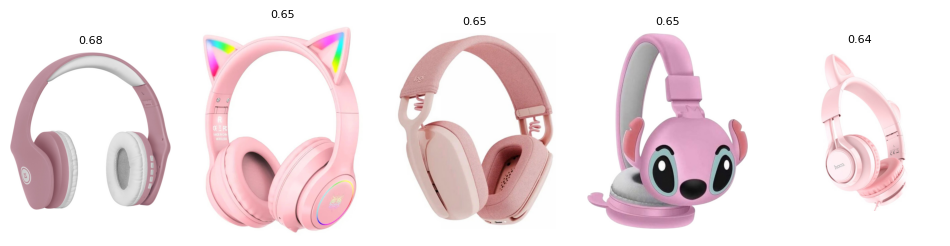


📝 Query Text: PS-115 column, black


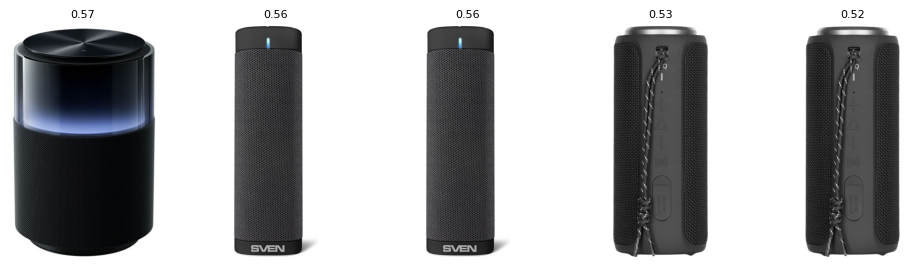


📝 Query Text: Designer socks with print, white/red, 38ru - 42ru


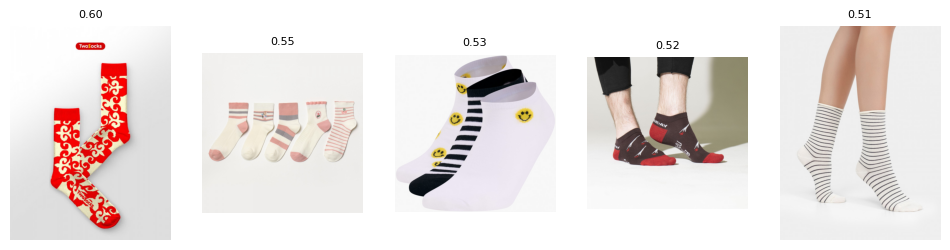


📝 Query Text: Telescopic pipe for LG vacuum cleaner


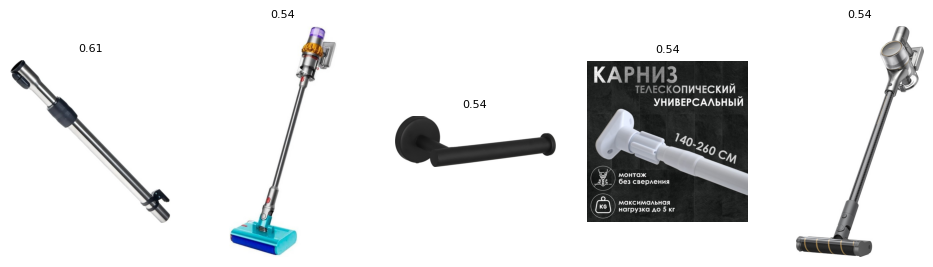


📝 Query Text: SSD drive SKC3000S/512G, 512 GB


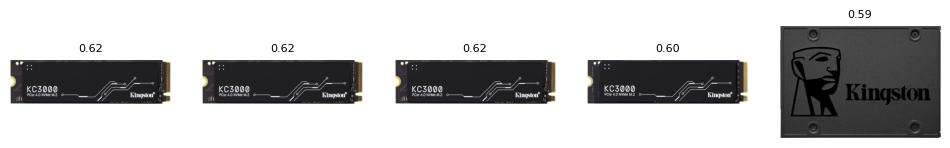

In [13]:
import random
from matplotlib import pyplot as plt
from PIL import Image
import torch.nn.functional as F

# --- Stack embeddings ---
all_image_embeddings = torch.stack([dataset[i][2] for i in range(len(dataset))])  # image embeddings
all_text_embeddings = torch.stack([dataset[i][3] for i in range(len(dataset))])   # text embeddings
all_texts = [dataset[i][1] for i in range(len(dataset))]
all_image_paths = [dataset[i][0] for i in range(len(dataset))]

# --- Normalize ---
all_image_embeddings = F.normalize(all_image_embeddings, dim=-1)
all_text_embeddings = F.normalize(all_text_embeddings, dim=-1)

# --- Pick 5 random text queries ---
num_queries = 5
query_indices = random.sample(range(len(dataset)), num_queries)

for q in query_indices:
    query_text = all_texts[q]
    query_embedding = all_text_embeddings[q].unsqueeze(0)  # (1, dim)

    # --- Compute text→image cosine similarities ---
    similarity_scores = (query_embedding @ all_image_embeddings.T).squeeze(0)

    # Top-5 most similar images
    topk = torch.topk(similarity_scores, k=5)
    top_indices = topk.indices.tolist()
    top_scores = topk.values.tolist()

    print(f"\n📝 Query Text: {query_text}")
    plt.figure(figsize=(12, 3))

    # Show 5 retrieved images
    for i, idx in enumerate(top_indices):
        plt.subplot(1, 5, i + 1)
        plt.imshow(Image.open(all_image_paths[idx]))
        plt.title(f"{top_scores[i]:.2f}", fontsize=8)
        plt.axis("off")

    plt.show()


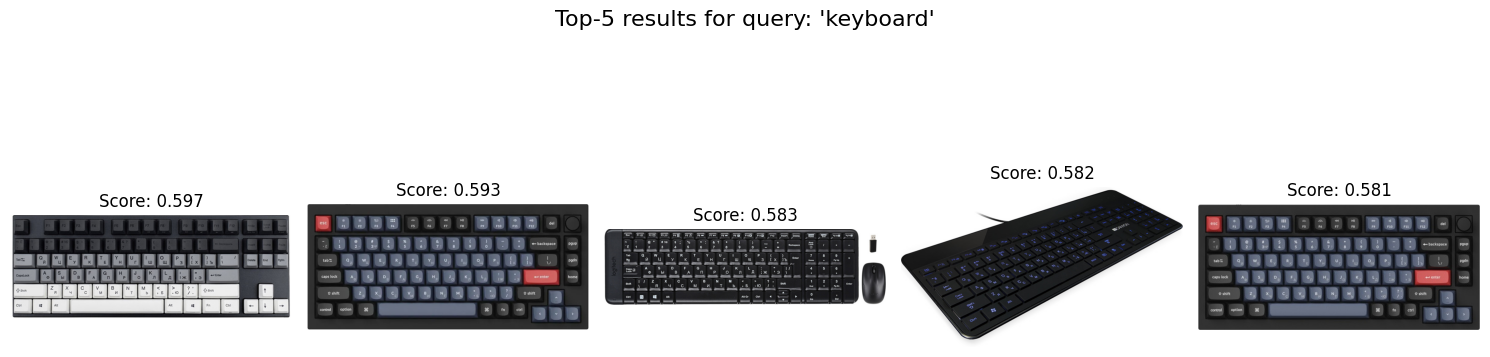

In [17]:
query_text_test = "keyboard"

query_text_test_processed = processor(text=query_text_test, return_tensors="pt").to('cuda')
query_embedding_test = model.get_text_features(**query_text_test_processed)

query_embedding_test = F.normalize(query_embedding_test, dim=-1).to('cuda')

# Ensure all_image_embeddings is on the same device as query_embedding_test
similarity_scores = (query_embedding_test @ all_image_embeddings.T.to('cuda')).squeeze(0)

# Top-5 most similar images
topk = torch.topk(similarity_scores, k=5)
top_indices = topk.indices.tolist()
top_scores = topk.values.tolist()


plt.figure(figsize=(15, 5))

for i, (idx, score) in enumerate(zip(top_indices, top_scores)):
    img_path = all_image_paths[idx]
    image = Image.open(img_path).convert("RGB")

    plt.subplot(1, 5, i + 1)
    plt.imshow(image)
    plt.title(f"Score: {score:.3f}")
    plt.axis("off")

plt.suptitle(f"Top-5 results for query: '{query_text_test}'", fontsize=16)
plt.tight_layout()
plt.show()

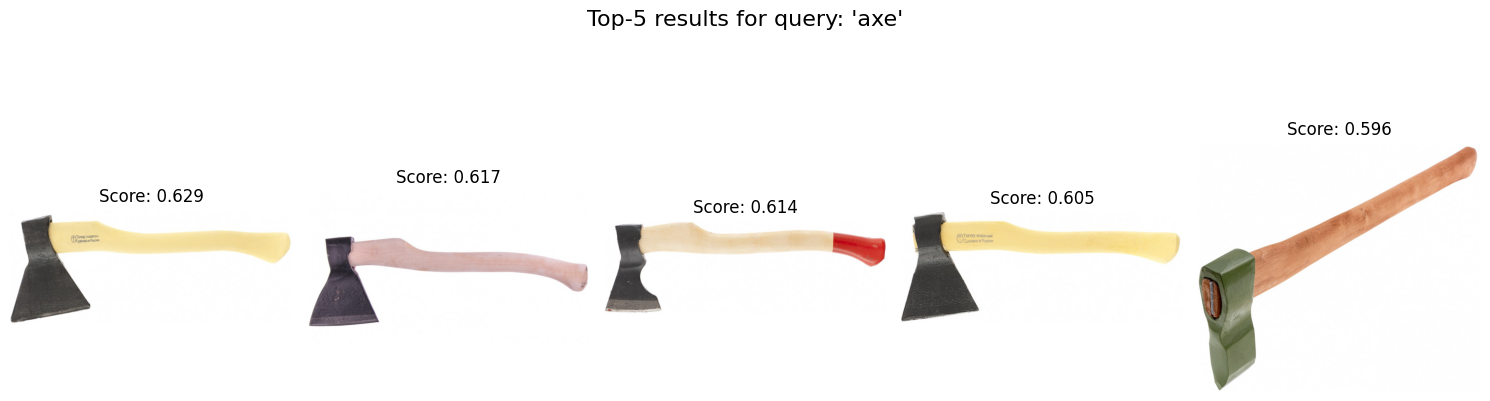

In [18]:
query_text_test = "axe"

query_text_test_processed = processor(text=query_text_test, return_tensors="pt").to('cuda')
query_embedding_test = model.get_text_features(**query_text_test_processed)

query_embedding_test = F.normalize(query_embedding_test, dim=-1).to('cuda')

# Ensure all_image_embeddings is on the same device as query_embedding_test
similarity_scores = (query_embedding_test @ all_image_embeddings.T.to('cuda')).squeeze(0)

# Top-5 most similar images
topk = torch.topk(similarity_scores, k=5)
top_indices = topk.indices.tolist()
top_scores = topk.values.tolist()


plt.figure(figsize=(15, 5))

for i, (idx, score) in enumerate(zip(top_indices, top_scores)):
    img_path = all_image_paths[idx]
    image = Image.open(img_path).convert("RGB")

    plt.subplot(1, 5, i + 1)
    plt.imshow(image)
    plt.title(f"Score: {score:.3f}")
    plt.axis("off")

plt.suptitle(f"Top-5 results for query: '{query_text_test}'", fontsize=16)
plt.tight_layout()
plt.show()

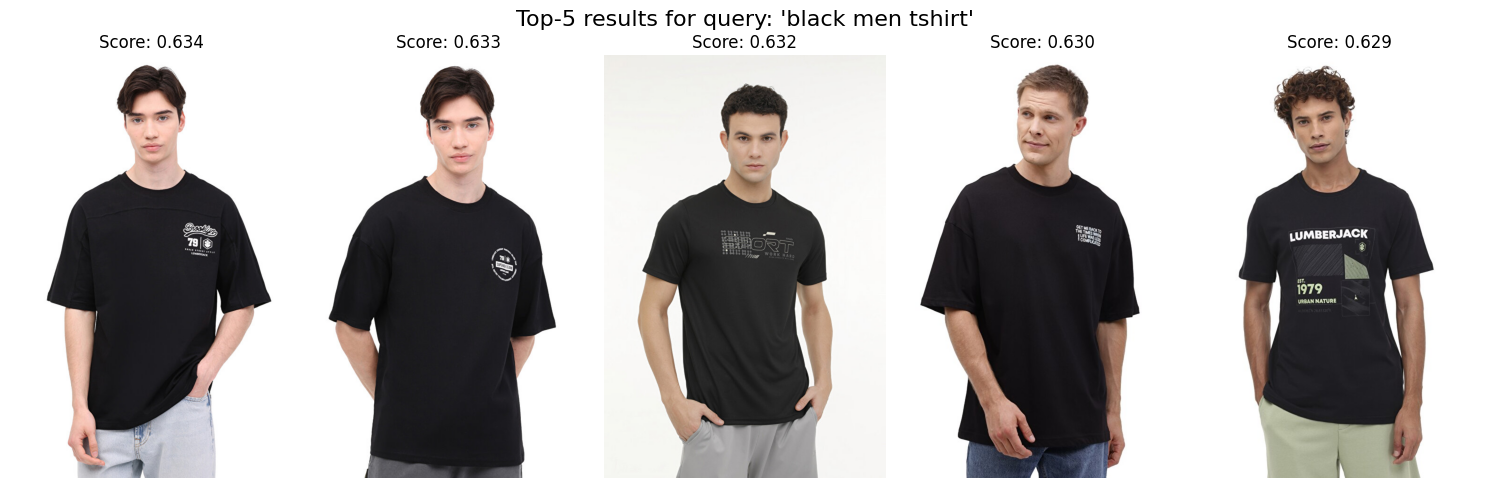

In [19]:
query_text_test = "black men tshirt"

query_text_test_processed = processor(text=query_text_test, return_tensors="pt").to('cuda')
query_embedding_test = model.get_text_features(**query_text_test_processed)

query_embedding_test = F.normalize(query_embedding_test, dim=-1).to('cuda')

# Ensure all_image_embeddings is on the same device as query_embedding_test
similarity_scores = (query_embedding_test @ all_image_embeddings.T.to('cuda')).squeeze(0)

# Top-5 most similar images
topk = torch.topk(similarity_scores, k=5)
top_indices = topk.indices.tolist()
top_scores = topk.values.tolist()


plt.figure(figsize=(15, 5))

for i, (idx, score) in enumerate(zip(top_indices, top_scores)):
    img_path = all_image_paths[idx]
    image = Image.open(img_path).convert("RGB")

    plt.subplot(1, 5, i + 1)
    plt.imshow(image)
    plt.title(f"Score: {score:.3f}")
    plt.axis("off")

plt.suptitle(f"Top-5 results for query: '{query_text_test}'", fontsize=16)
plt.tight_layout()
plt.show()